[View in Colaboratory](https://colab.research.google.com/github/keicoon/AutoEncoder/blob/master/SAE.ipynb)

## MNIST example in Sparse Auto Encoder
- refence : https://web.stanford.edu/class/cs294a/sparseAutoencoder_2011new.pdf

In [3]:
!pip install tqdm

    100% |████████████████████████████████| 51kB 2.4MB/s 


In [4]:
import numpy as np
import tensorflow as tf

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [5]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
class SAE():
  def __init__(self, n_input, n_hidden, rho=0.01, lamb=0.0001, beta=3, activation=tf.nn.sigmoid):
    n_output = n_input
  
    self.W1 = tf.get_variable("W1", shape=(n_input, n_hidden), initializer=tf.contrib.layers.xavier_initializer())
    self.b1 = tf.Variable(tf.zeros([n_hidden], dtype = tf.float32))

    self.W2 = tf.Variable(tf.zeros([n_hidden, n_output], dtype = tf.float32))
    self.b2 = tf.Variable(tf.zeros([n_output], dtype = tf.float32))
    
    self.rho = rho
    self.lamb = lamb
    self.beta = beta
    
    self.activation = activation
    
  def encode(self, X):
    h = tf.matmul(X, self.W1) + self.b1
    return self.activation(h)
  
  def decode(self, hidden):
    _X = tf.matmul(hidden, self.W2) + self.b2
    return self.activation(_X)
  
  def kl_divergence(self, r, r_hat):
    return r * (tf.log(r) - tf.log(r_hat)) + (1 - r) * (tf.log(1 - r) - tf.log(1 - r_hat))

  def __call__(self, X):
    h = self.encode(X)
    _X = self.decode(h)
    #
    r_hat = tf.reduce_mean(h, axis=0)
    kl = self.kl_divergence(self.rho, r_hat)
    #
    mse = tf.reduce_mean(tf.reduce_sum(tf.square(X - _X)))
    J = 0.5 * (mse + self.lamb * (tf.nn.l2_loss(self.W1) + tf.nn.l2_loss(self.W2)))
    penalty = self.beta * tf.reduce_sum(kl)
    
    self.cost = J + penalty
    
    return _X

In [0]:
class simple_SAE():
  def __init__(self, n_hidden, rho=0.01, beta=3, activation=tf.nn.relu):
    self.n_hidden = n_hidden
    self.activation = activation
    # rho is sparsity parameter
    self.rho = rho
    # beta is controls the weight of the sparsity penalty term
    self.beta = beta
  
  def kl_divergence(self, r, r_hat):
    return r * (tf.log(r) - tf.log(r_hat)) + (1 - r) * (tf.log(1 - r) - tf.log(1 - r_hat))
  
  def __call__(self, X):
    # model
    h = tf.layers.dense(X, self.n_hidden, activation=self.activation, kernel_initializer=tf.contrib.layers.xavier_initializer())
    _X = tf.layers.dense(h, 784, activation=self.activation)
    # kl
    r_hat = tf.reduce_mean(h)
    kl = self.kl_divergence(self.rho, r_hat)
    
    penalty = self.beta * tf.reduce_sum(kl)
    recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(X - _X)))
    
    self.cost = recon_loss + penalty
    
    return _X

In [0]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

tf.reset_default_graph()

batch_size = 256
n_samples = int(mnist.train.num_examples)
total_batch = int(n_samples / batch_size)

# sae = SAE(784, 1024)
sae = simple_SAE(1024)

X = tf.placeholder(tf.float32, [None, 784])
_X = sae(X)

train_op = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(sae.cost)

sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

In [10]:
def train():
  training_epochs = 15
  
  for epoch in range(training_epochs):
    avg_cost = 0.
    
    pbar = tqdm(range(total_batch))
    
    for i in pbar:
      batch_x, _ = mnist.train.next_batch(batch_size, shuffle=True)
      
      _, cost = sess.run([train_op, sae.cost], feed_dict={X: batch_x})
      
      avg_cost += cost / total_batch
      pbar.set_description("cost : %f" % avg_cost)
    

train()

cost : 46.933625:   0%|          | 0/214 [00:00<?, ?it/s]

cost : 47.537401:   5%|▌         | 11/214 [00:00<00:02, 91.77it/s]

cost : 46.401565:   5%|▌         | 11/214 [00:00<00:02, 93.14it/s] 

cost : 54.685519:   6%|▌         | 13/214 [00:00<00:01, 113.75it/s]

cost : 876.910969: 100%|██████████| 214/214 [00:01<00:00, 107.19it/s]


Original Images


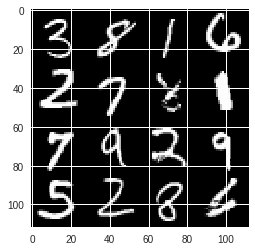

Reconstructed Images


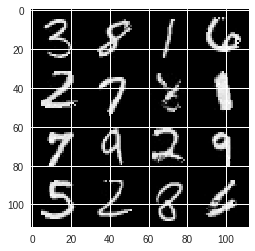

In [11]:
def test():
  n = 4
    
  canvas_orig = np.empty((28 * n, 28 * n))
  canvas_recon = np.empty((28 * n, 28 * n))
  for i in range(n):
      batch_x, _ = mnist.test.next_batch(n)

      recon = sess.run(_X, feed_dict={X: batch_x})

      # Display original images
      for j in range(n):
          # Draw the generated digits
          canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = batch_x[j].reshape([28, 28])
      # Display reconstructed images
      for j in range(n):
          # Draw the generated digits
          canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = recon[j].reshape([28, 28])

  print("Original Images")     
  plt.figure(figsize=(n, n))
  plt.imshow(canvas_orig, origin="upper", cmap="gray")
  plt.show()

  print("Reconstructed Images")
  plt.figure(figsize=(n, n))
  plt.imshow(canvas_recon, origin="upper", cmap="gray")
  plt.show()

test()